In [154]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [155]:
data_path = os.path.join('..', 'data', 'training', '0a938d79.json')

with open(data_path, 'r') as f:
  data = json.load(f)

In [158]:
def pad_data_to_30x30(data):
    # Convert input to numpy array if it's not already
    data = np.array(data)
    
    # Initialize a 30x30 array filled with -1
    padded_data = np.full((30, 30), -1, dtype=int)
    
    # Copy data to padded_data
    rows, cols = data.shape
    padded_data[:rows, :cols] = data[:30, :30]
    
    return padded_data

def visualize_grid(data):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    
    if data.ndim != 2:
        raise ValueError("Input must be a 2D array")
    
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.suptitle("Visualization of 2D Padded Data", fontsize=16)
    
    # Create a custom colormap
    cmap = plt.cm.get_cmap('tab10')
    colors = [cmap(i) for i in range(10)]
    custom_cmap = plt.cm.colors.ListedColormap(['lightgrey'] + colors + ['darkred'])
    
    # Create bounds and norm for the colormap
    bounds = list(range(-2, 11))  # This creates [-2, -1, 0, 1, ..., 10]
    norm = plt.cm.colors.BoundaryNorm(bounds, custom_cmap.N)
    
    im = ax.imshow(data, cmap=custom_cmap, norm=norm, interpolation='nearest')
    ax.set_title("Padded Grid")
    
    # Add grid lines
    ax.set_xticks(np.arange(-0.5, 30, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 30, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_ticks(range(-1, 11))
    cbar.set_ticklabels(['-1 (pad)'] + list(range(10)) + ['10+'])
    
    plt.tight_layout()
    plt.show()


def encode_grid(grid):
    """Convert a 2D grid to a 11-channel 3D tensor."""
    encoded = np.zeros((11, 30, 30), dtype=np.float32)
    for i in range(30):
        for j in range(30):
            value = grid[i, j]
            if -1 <= value <= 9:
                encoded[value + 1, i, j] = 1
    return encoded

In [159]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)

class EnhancedMultiChannelCNN(nn.Module):
    def __init__(self, num_residual_blocks=3):
        super(EnhancedMultiChannelCNN, self).__init__()
        
        # Grid processing branch
        self.conv1_grid = nn.Conv2d(11, 32, kernel_size=3, padding=1)
        self.bn1_grid = nn.BatchNorm2d(32)
        
        # Change memory projection to output the correct size
        self.memory_proj = nn.Linear(900, 28800)  # 900 -> (32 * 30 * 30)
        
        # Combined processing
        self.conv_combine = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn_combine = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_residual_blocks)]
        )
        
        self.conv_final = nn.Conv2d(64, 11, kernel_size=3, padding=1)

    def forward(self, grid, memory):
        batch_size = grid.size(0)
        
        # Process grid input
        x_grid = self.relu(self.bn1_grid(self.conv1_grid(grid)))  # [batch_size, 32, 30, 30]
        
        # Process memory input
        memory = memory.view(1, 900)  # [1, 900]
        memory_batch = memory.expand(batch_size, -1)  # [batch_size, 900]
        memory_proj = self.memory_proj(memory_batch)  # [batch_size, 28800]
        memory_spatial = memory_proj.view(batch_size, 32, 30, 30)  # [batch_size, 32, 30, 30]
        memory_features = self.relu(memory_spatial)
        
        # Concatenate along channel dimension
        x_combined = torch.cat([x_grid, memory_features], dim=1)  # [batch_size, 64, 30, 30]
        
        # Rest of the forward pass
        x = self.relu(self.bn_combine(self.conv_combine(x_combined)))
        x = self.residual_blocks(x)
        x = self.conv_final(x)
        return x

In [184]:
X = torch.tensor([encode_grid(pad_data_to_30x30(ex['input'])) for ex in data['train']])
Y = torch.tensor([encode_grid(pad_data_to_30x30(ex['output'])) for ex in data['train']])

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = EnhancedMultiChannelCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

memory = torch.rand(30, 30) * 2 - 1  # Random values between -1 and 1

In [193]:
optimizer = optim.Adam(model.parameters())

for param in model.parameters():
    param.requires_grad = True

memory.requires_grad_(False)  # Disable gradient tracking

num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs, memory)
        loss = criterion(outputs, targets.argmax(dim=1))
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.1449
Epoch [20/100], Loss: 0.0636
Epoch [30/100], Loss: 0.0299
Epoch [40/100], Loss: 0.0136
Epoch [50/100], Loss: 0.0058
Epoch [60/100], Loss: 0.0026
Epoch [70/100], Loss: 0.0014
Epoch [80/100], Loss: 0.0009
Epoch [90/100], Loss: 0.0007
Epoch [100/100], Loss: 0.0005


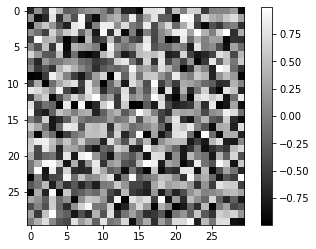

In [185]:
def visualize_memory():
    plt.imshow(memory.detach().numpy(), cmap='gray')
    plt.colorbar()
    plt.show()

visualize_memory()

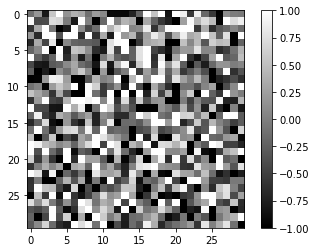

In [197]:
visualize_memory()

In [187]:
for param in model.parameters():
    param.requires_grad = False

memory.requires_grad_()  # Enable gradient tracking
optimizer = torch.optim.SGD([memory], lr=10)

In [191]:
num_epochs = 1000
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs, memory)
        loss = criterion(outputs, targets.argmax(dim=1))
        loss.backward()
        
        # print('Memory Gradient Norm:', memory_grad_norm)
        
        optimizer.step()
        memory.grad.zero_()

        # Optional: Clamp memory values to keep them within a desired range
        with torch.no_grad():
            memory.clamp_(-1, 1)
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 2.5254
Epoch [200/1000], Loss: 2.5246
Epoch [300/1000], Loss: 2.5232
Epoch [400/1000], Loss: 2.5223
Epoch [500/1000], Loss: 2.5215
Epoch [600/1000], Loss: 2.5206
Epoch [700/1000], Loss: 2.5199
Epoch [800/1000], Loss: 2.5192
Epoch [900/1000], Loss: 2.5184
Epoch [1000/1000], Loss: 2.5175


In [11]:
# Save the trained model
torch.save(model.state_dict(), 'linear_static_dictionary.pth')

In [194]:
def predict(input_data):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(encode_grid(pad_data_to_30x30(input_data))).unsqueeze(0)
        output = model(input_tensor, memory)
        return output.argmax(dim=1).squeeze().numpy() - 1  # Convert back to [-1, 9] range
    
# Function to visualize prediction
def visualize_prediction(input_data):
    predicted_output = predict(input_data)
    visualize_grid(predicted_output)

def visualize_actual(data):
    visualize_grid(pad_data_to_30x30(data['output']))
    visualize_grid(pad_data_to_30x30(data['input']))


<ipython-input-158-d4744d680ca9>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


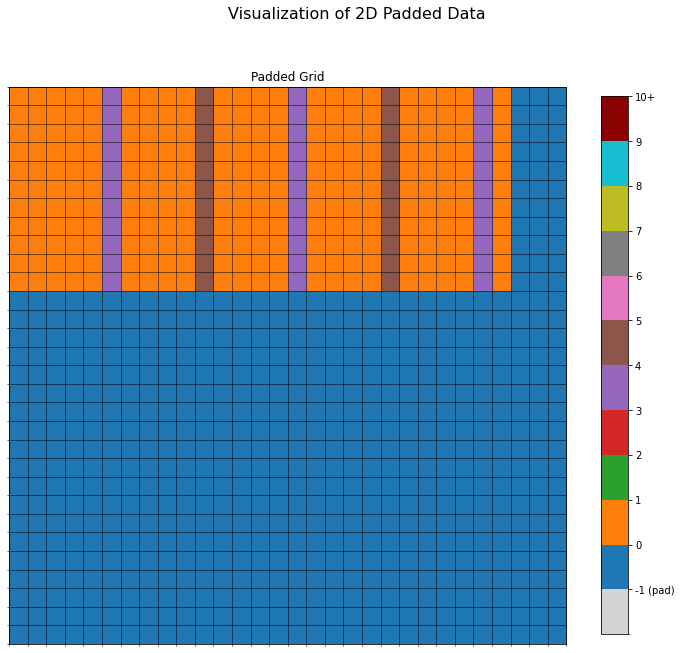

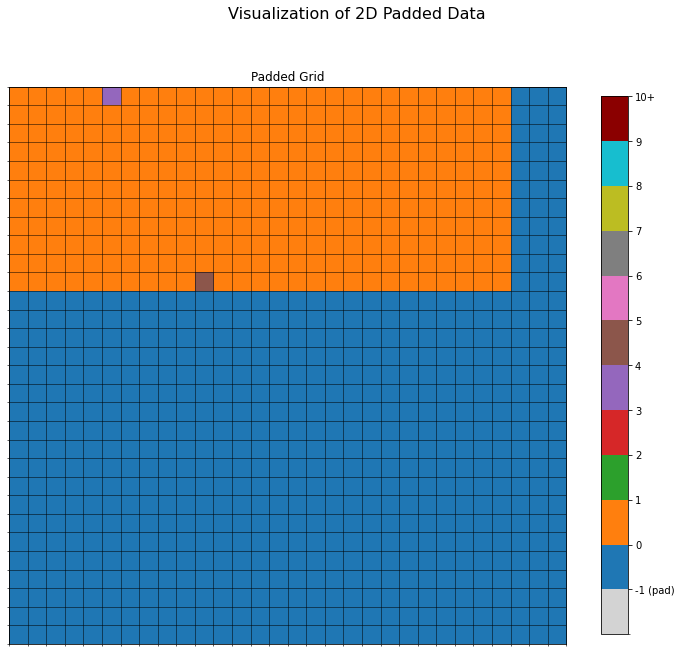

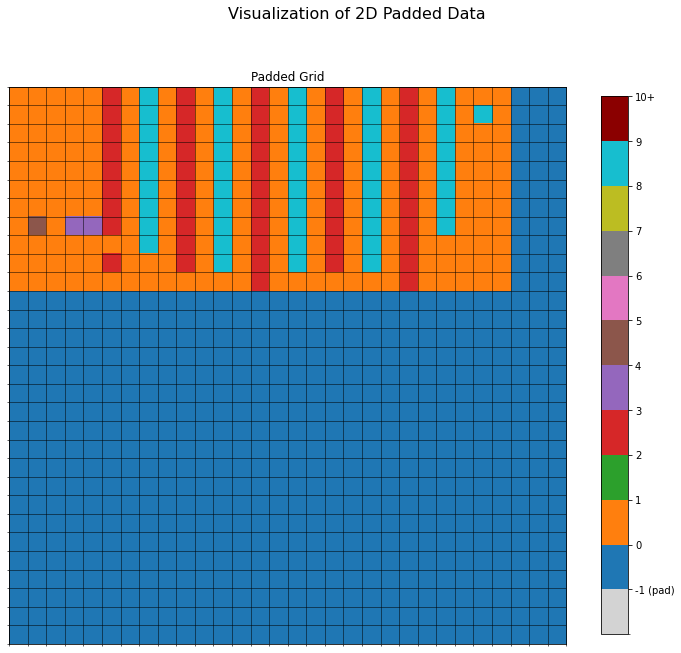

In [196]:
x_test = data['test'][0]
visualize_actual(x_test)
visualize_prediction(x_test['input'])
